# This notebook plots the number density of CCS on a map

## To speedup the notebook, the CCS track counts on grid map is precalculated by:
* /src/count_tracks_on_gridmap.py

In [1]:
import numpy as np
import xarray as xr
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import seaborn as sns
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import shapely.geometry as sgeom
from itertools import chain
import copy
%matplotlib inline

In [2]:
# run_name = 'mpi'
# run_name = 'scream'
# run_name = 'noaa'
# run_name = 'nicam'
# run_name = 'nasa'
run_name = 'uk'

# Dictionary for official model names
model_name = {
    'scream': 'SCREAM',
    'mpi': 'ICON',
    'nasa': 'GEOS',
    'nicam': 'NICAM',
    'uk': 'UM',
    'noaa': 'X-SHiELD',
}

# Turn on xlabel for UK model
if run_name == 'uk':
    xlabel_m = True
else:
    xlabel_m = False
    
# Bounds for comparing CCS lifetime-area joint KDE
region = 'tropics'
lon_bounds = [0, 360]
lat_bounds = [-20, 15]
lifetime_bounds = [2,60]

test = ''
# test = '_ccs1_2h'
rootdir = '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/'
obsdir = f'{rootdir}obs/stats{test}/monthly/'
moddir = f'{rootdir}{run_name}/stats{test}/monthly/'
obsfile = f'{obsdir}track_counts_gridmap_20200201_20200301.nc'
modfile = f'{moddir}track_counts_gridmap_20200201_20200301.nc'

topfile = '/global/cfs/cdirs/m1867/zfeng/gpm/map_data/era5_orography.nc'

# figdir = f'/global/cfs/cdirs/m1867/zfeng/dyamond-winter/figures{test}/'
figdir = f'/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures{test}/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures/


In [4]:
obsfile, modfile

('/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/obs/stats/monthly/track_counts_gridmap_20200201_20200301.nc',
 '/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/uk/stats/monthly/track_counts_gridmap_20200201_20200301.nc')

# These customed functions enables use of [NCL colormaps](https://www.ncl.ucar.edu/Document/Graphics/color_table_gallery.shtml)

In [5]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # finally convert rgb colors back to hex
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))

        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python

    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])

    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    #     white_ext:     whether to add this above white as an extended color (when set to True), or just replace the first color (when set to False).
    #     reverse_cmap:  similar to "_r" in colormap.
    # note:  reverse_cmap is applied first, then white_first option.

    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)

    if reverse_cmap==True:
        cmap_discrete_raw.reverse()

    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw

    if cont_opt==False:
        out_cmap = cmap_discrete

    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])

    return mpl.colors.ListedColormap(out_cmap)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [6]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.z.sel(latitude=slice(61,-61)).squeeze() / 9.80665
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.longitude
lat_ter = dstop.latitude.sel(latitude=slice(61,-61))
ter

<xarray.DataArray 'z' (latitude: 489, longitude: 1440)>
array([[-0.19099763, -0.2824136 ,  0.17526372, ...,  1.1824327 ,
         0.35849398,  0.26687884],
       [-0.19099763,  0.54152507,  0.35849398, ...,  2.2812166 ,
         1.3656629 ,  0.9994015 ],
       [-1.656043  , -0.9235203 ,  0.08384776, ...,  7.134229  ,
         0.9077864 , -0.55725896],
       ...,
       [ 0.35849398,  0.17526372,  0.17526372, ..., -0.46564385,
        -0.3740287 ,  0.17526372],
       [-0.3740287 , -0.0993825 ,  0.08384776, ...,  0.35849398,
         0.17526372,  0.17526372],
       [-0.00776737,  0.26687884, -0.00776737, ...,  0.08384776,
         0.17526372,  0.54152507]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 61.0 60.75 60.5 60.25 ... -60.5 -60.75 -61.0
    time       datetime64[ns] 1979-01-01

In [7]:
# Read OBS data
dsobs = xr.open_dataset(obsfile)
dsobs

<xarray.Dataset>
Dimensions:       (time: 1, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 360.0
Data variables:
    track_counts  (time, lat, lon) float32 ...
Attributes:
    title:       Track counts on grid
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue Sep 27 12:11:57 2022

In [8]:
# Read MODEL data
dsm1 = xr.open_dataset(modfile)
dsm1

<xarray.Dataset>
Dimensions:       (time: 1, lat: 120, lon: 360, lat_bnds: 121, lon_bnds: 361)
Coordinates:
  * time          (time) datetime64[ns] 2020-02-01
  * lat           (lat) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5 59.5
  * lon           (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat_bnds      (lat_bnds) float64 -60.0 -59.0 -58.0 -57.0 ... 58.0 59.0 60.0
  * lon_bnds      (lon_bnds) float64 0.0 1.0 2.0 3.0 ... 357.0 358.0 359.0 360.0
Data variables:
    track_counts  (time, lat, lon) float32 ...
Attributes:
    title:       Track counts on grid
    start_date:  2020-02-01T00
    end_date:    2020-03-01T00
    contact:     Zhe Feng, zhe.feng@pnnl.gov
    created_on:  Tue Sep 27 12:12:47 2022

In [9]:
# ranges = [[-60,60], [0,360]]
# xbins = np.arange(0, 360.1, 1)
# ybins = np.arange(-60., 60.1, 1)
xbins = dsobs['lon_bnds']
ybins = dsobs['lat_bnds']
# Get lat/lon bin center value
lonbins = dsobs['lon']
latbins = dsobs['lat']

In [10]:
ccs_number_obs = dsobs['track_counts'].squeeze()
ccs_number_mod = dsm1['track_counts'].squeeze()

In [11]:
np.nanmax(ccs_number_obs)

72.0

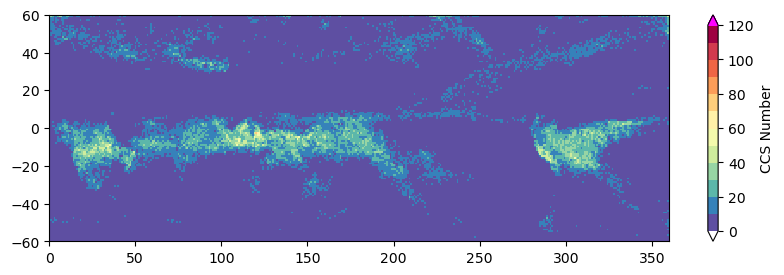

In [12]:
fig = plt.figure(figsize=[10,3], dpi=100)
# levels = [1,2,4,7,10,13,16,20]
levels = np.arange(0,121,10)
cmap = copy.copy(mpl.cm.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, ccs_number_obs, norm=norm, cmap=cmap)
plt.colorbar(label='CCS Number', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

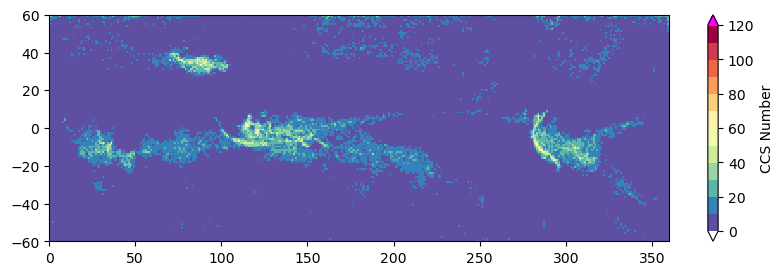

In [13]:
fig = plt.figure(figsize=[10,3], dpi=100)
levels = np.arange(0,121,10)
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
pcm = plt.pcolormesh(xbins, ybins, ccs_number_mod, norm=norm, cmap=cmap)
plt.colorbar(label='CCS Number', extend='both')
pcm.cmap.set_over('magenta')
pcm.cmap.set_under('white')

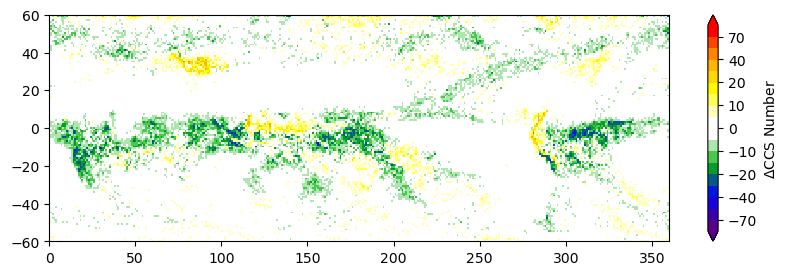

In [14]:
diff = ccs_number_mod - ccs_number_obs
fig = plt.figure(figsize=[10,3], dpi=100)
# levels = np.arange(-100,101,10)
levels = [-100,-70,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,70,100]
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe')
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
pcm = plt.pcolormesh(xbins, ybins, diff, norm=norm, cmap=cmap)
plt.colorbar(label='$\Delta$CCS Number', extend='both')
# pcm.cmap.set_over('magenta')
# pcm.cmap.set_under('white')

## Plotting Function

In [16]:
def plot_map_single(dataarray, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                    oob_colors=None, mask=None, contourf=False, boxes=None, boxtextloc=None, boxtext=None, clev_colors=None,
                    xlabel=True, ylabel=True, colorbar=True, boxtexttype=None, figsize=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)

    fig = plt.figure(figsize=figsize, dpi=100)
    ax = plt.subplot(111, projection=proj)
    ax.set_extent(map_extend, crs=proj)
    ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
    # ax.set_title(title, loc='left')
    ax.set_aspect('auto', adjustable=None) 
    flabel = ax.text(0.02, 0.05, title, transform=ax.transAxes, fontsize=14)
    flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))

    gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
    gl.xlocator = mpl.ticker.FixedLocator(lonv)
    gl.ylocator = mpl.ticker.FixedLocator(latv)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    if xlabel is True:
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_xticks(lonv, crs=ccrs.PlateCarree())
    if ylabel is True:
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())

    # Terrain height
    ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                    colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)

    # Plot data
    cmap = copy.copy(mpl.cm.get_cmap(cmap))
    norm = colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    Zm1 = dataarray[0]
    Zm1s = gaussian_filter(Zm1, 0.5)
    if (contourf == False):
        pcm1 = ax.pcolormesh(lonarr[0], latarr[0], Zm1, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
    else:
        pcm1 = ax.contourf(lonarr[0], latarr[0], Zm1s, levels=levels, norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)
        
    # Set out of bound colors
    if oob_colors is not None:
        pcm1.cmap.set_over(oob_colors['over'])
        pcm1.cmap.set_under(oob_colors['under'])
        pcm1.set_clim(min(levels), max(levels))
    # Plot colorbar
    if colorbar == True:
        if (contourf == False):
            cb = plt.colorbar(pcm1, label=cblabel, pad=0.02, ticks=cbticks, extend='both')
        else:
            cb = plt.colorbar(pcm1, label=cblabel, pad=0.02, ticks=cbticks)

    # Plot boxes
    if boxes is not None:
        for ii in boxes:
            box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
            ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=2, zorder=5)
            if boxtexttype is None:
                text_color = clev_colors['pos'] if (boxtext[ii] >=0) else clev_colors['neg']
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]:.00f}%", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)
            else:
                text_color = 'k'
                ax.text(boxtextloc[ii][0], boxtextloc[ii][1], f"{boxtext[ii]}", ha='center',
                        bbox=dict(facecolor='w', alpha=0.8, edgecolor=text_color),
                        fontsize=12, fontweight='bold', color=text_color, transform=ccrs.PlateCarree(), zorder=4)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

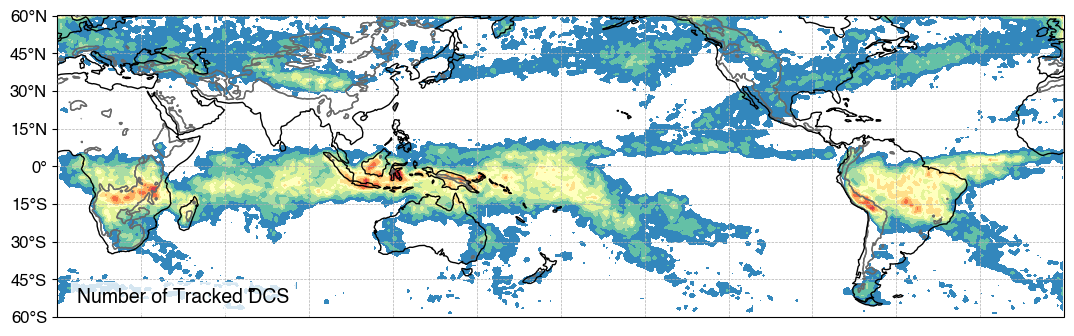

In [17]:
title = 'Number of Tracked DCS'
dataarr = [ccs_number_obs]
lonarr = [lonbins, lonbins]
latarr = [latbins, latbins]
levels = np.arange(5,51,5)
cbticks = np.arange(5,51,5)
cblabel = 'Number of CCS (OBS)'
cmap = copy.copy(plt.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.1, 0.9)
figname = f'{figdir}globalmap_ccs_number_map_obs.png'
oob_colors = {'under':'white', 'over':'firebrick'}
fig = plot_map_single(dataarr, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=True, xlabel=False, colorbar=False, figsize=[13,4])

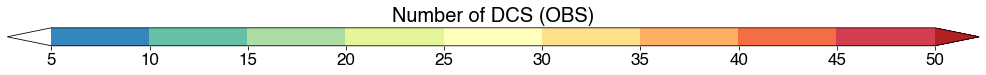

In [18]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
cmap = copy.copy(mpl.cm.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.1, 0.9)
oob_colors = {'under':'white', 'over':'firebrick'}
cmap.set_over(oob_colors['over'])
cmap.set_under(oob_colors['under'])
levels = np.arange(5,51,5)
cbticks = levels
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = 'Number of DCS (OBS)'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.ax.set_title(cblabel, size=20)
figname = f'{figdir}globalmap_ccs_number_obs_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

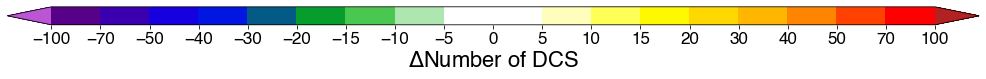

In [19]:
mpl.rcParams['font.size'] = 17
mpl.rcParams['font.family'] = 'Helvetica'
fig = plt.figure(figsize=[15,1])
ax = fig.add_axes([0.05, 0.10, 0.9, 0.25])
# levels = np.arange(-100, 101, 10)
# cbticks = np.arange(-100, 101, 20)
levels = [-100,-70,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,70,100]
cbticks = levels
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe')
oob_colors = {'under':'mediumorchid', 'over':'firebrick'}
cmap.set_over(oob_colors['over'])
cmap.set_under(oob_colors['under'])
norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N)
cblabel = '$\Delta$Number of DCS'
cb = mpl.colorbar.ColorbarBase(ax, ticks=cbticks, extend='both', norm=norm, cmap=cmap, orientation='horizontal', )
cb.set_label(label=cblabel, size=22)
figname = f'{figdir}globalmap_ccs_number_diff_colorbar.png'
fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')

In [20]:
box_mc = [95,150,-20,5]
box_itcz = [151,250,0,12]
box_spcz = [151,210,-30,-1]
box_io = [50,94,-15,5]
box_afc = [10,40,-20,5]
box_amz = [-75%360,-40%360,-20,0]
box_ao = [-40%360,-10%360,-8,8]
box_amz180 = [-75,-40,-20,0]
box_ao180 = [-40,-10,-8,8]
boxes = {'maritime_continent':box_mc, 
         'itcz':box_itcz, 
         'spcz':box_spcz, 
         'indian_ocean':box_io, 
         'africa':box_afc, 
         'amazon':box_amz, 
         'atlantic_ocean':box_ao}
# For plotting only
boxes4plot = copy.deepcopy(boxes)
boxes4plot['amazon'] = box_amz180
boxes4plot['atlantic_ocean'] = box_ao180
boxes['amazon'][0]
# box_amz

285

In [21]:
# Calculate regional mean difference
diff_reg = np.zeros(len(boxes), dtype=float)
text_loc_x = np.zeros(len(boxes), dtype=float)
# for ii in range(len(boxes)):
for ii, name in enumerate(boxes):
    # print(name)
    xid = np.where((lonbins >= boxes[name][0]) & (lonbins <= boxes[name][1]))[0]
    yid = np.where((latbins >= boxes[name][2]) & (latbins <= boxes[name][3]))[0]
    text_loc_x[ii] = boxes[name][0] + (boxes[name][1] - boxes[name][0])/2.
    # Calculate mean difference in percentage
    val_mod = ccs_number_mod[min(yid):max(yid), min(xid):max(xid)]
    val_obs = ccs_number_obs[min(yid):max(yid), min(xid):max(xid)]
    diff_reg[ii] = 100 * (np.nansum(val_mod) - np.nansum(val_obs)) / np.nansum(val_obs)
    # print(f'{diff_reg:.00f}%')
# print(diff_reg)

text_loc_y = [box_mc[2]-8, box_itcz[3]+3, box_spcz[2]-8, box_io[3]+3, box_afc[3]+3, box_amz[3]+3, box_ao[3]+3]
text_loc = dict(zip(boxes.keys(), zip(text_loc_x, text_loc_y)))
text_val = dict(zip(boxes.keys(), diff_reg))
print(text_loc)
print(text_val)

{'maritime_continent': (122.5, -28), 'itcz': (200.5, 15), 'spcz': (180.5, -38), 'indian_ocean': (72.0, 8), 'africa': (25.0, 8), 'amazon': (302.5, 3), 'atlantic_ocean': (335.0, 11)}
{'maritime_continent': -16.23865776408149, 'itcz': -45.527121609798776, 'spcz': -32.03265878581447, 'indian_ocean': -43.76668236771864, 'africa': -45.17751694977036, 'amazon': -25.639934334529094, 'atlantic_ocean': -62.08924247665168}


## Plot OBS with region box names

{'maritime_continent': 'MC', 'itcz': 'ITCZ', 'spcz': 'SPCZ', 'indian_ocean': 'IO', 'africa': 'AFC', 'amazon': 'AMZ', 'atlantic_ocean': 'AO'}


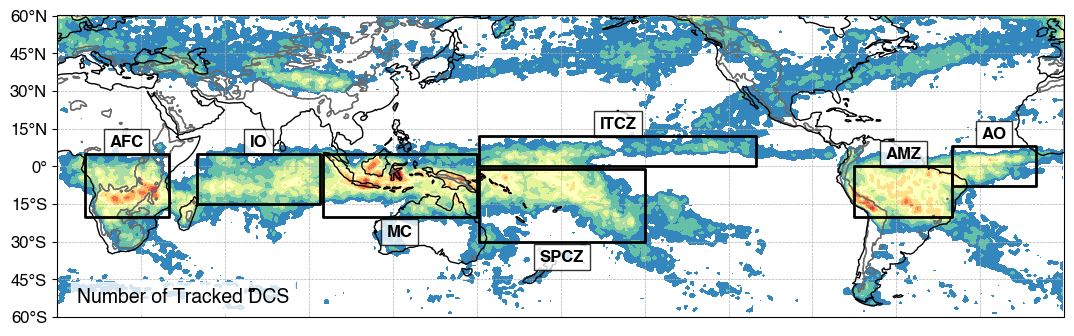

In [22]:
reg_names = ['MC', 'ITCZ', 'SPCZ', 'IO', 'AFC', 'AMZ', 'AO']
region_names = dict(zip(boxes.keys(), reg_names))
print(region_names)

title = 'Number of Tracked DCS'
dataarr = [ccs_number_obs]
lonarr = [lonbins, lonbins]
latarr = [latbins, latbins]
levels = np.arange(5,51,5)
cbticks = np.arange(5,51,5)
cblabel = 'Number of CCS (OBS)'
cmap = copy.copy(plt.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.1, 0.9)
figname = f'{figdir}globalmap_ccs_number_map_obs_regionboxes.png'
oob_colors = {'under':'white', 'over':'firebrick'}
fig = plot_map_single(dataarr, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=True, boxes=boxes4plot, boxtextloc=text_loc, boxtext=region_names, boxtexttype='string', 
                      xlabel=False, colorbar=False, figsize=[13,4])

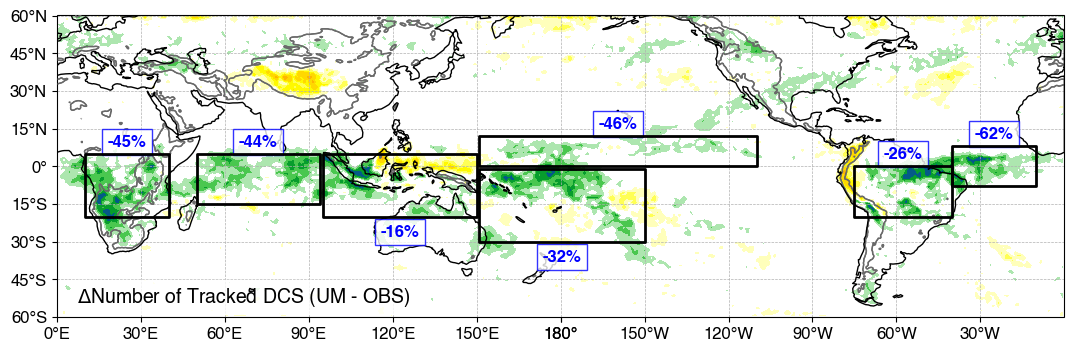

In [24]:
title = f'$\Delta$Number of Tracked DCS ({model_name[run_name]} - OBS)'
diff = ccs_number_mod - ccs_number_obs

dataarr = [diff]
lonarr = [lonbins, lonbins]
latarr = [latbins, latbins]
# levels = np.arange(-100, 101, 10)
# cbticks = np.arange(-100, 101, 20)
levels = [-100,-70,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,70,100]
cbticks = levels
clev_colors = {'pos':'orangered', 'neg':'blue'}
# text_colors = {'pos':'orangered', 'neg':'blue'}
cblabel = '$\Delta$Number of DCS'
cmap = generate_NCL_cmap('ViBlGrWhYeOrRe')
figname = f'{figdir}globalmap_ccs_number_map_diff_{run_name}.png'
oob_colors = {'under':'mediumorchid', 'over':'firebrick'}
fig = plot_map_single(dataarr, lonarr, latarr, levels, cmap, cblabel, cbticks, title, figname, 
                      oob_colors=oob_colors, contourf=True, boxes=boxes4plot, boxtextloc=text_loc, boxtext=text_val, clev_colors=clev_colors,
                      xlabel=xlabel_m, colorbar=False, figsize=[13,4],)

In [25]:
figdir

'/global/cfs/cdirs/m1867/DYAMOND/dyamond-winter/figures/'

In [26]:
def plot_3maps(dataarray, lon, lat, titles, levels, cmaps, cblabels, cbticks, figname, oob_colors=None, contourf=False, boxes=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extend = [0., 359.5, -60.1, 60.1]
    lonv = np.arange(-180,180.1,30)
    latv = np.arange(-60,60.1,15)
    proj = ccrs.PlateCarree(central_longitude=180)
    levelshgt = [1000,10000]

    fig = plt.figure(figsize=[12,12], dpi=100)
    gs = gridspec.GridSpec(3,2, height_ratios=[1,1,1], width_ratios=[1,0.02])
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.9, wspace=0.05, hspace=0.14)

    resolution = '110m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    
    for pp in range(0,3):
        data = dataarray[pp]

        ax = plt.subplot(gs[pp,0], projection=proj)
        ax.set_extent(map_extend, crs=proj)
        ax.add_feature(land, facecolor='none', edgecolor='k', zorder=3)
        ax.set_title(titles[pp], loc='left')
        ax.set_aspect('auto', adjustable=None)
        gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
        gl.xlocator = mpl.ticker.FixedLocator(lonv)
        gl.ylocator = mpl.ticker.FixedLocator(latv)
            
        if (pp == 2):
            ax.set_xticks(lonv, crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            ax.xaxis.set_major_formatter(lon_formatter)
        ax.set_yticks(latv, crs=ccrs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        
        # Terrain height
        ct = ax.contour(lon_ter, lat_ter, ter_s, levels=[1000,1001], \
                        colors='dimgray', linewidths=1, transform=ccrs.PlateCarree(), zorder=3)
        
        Zm = np.ma.masked_where(((data == 0) | (np.isnan(data))), data)
        cmap = plt.get_cmap(cmaps[pp])
        norm = colors.BoundaryNorm(boundaries=levels[pp], ncolors=cmap.N)
        
        Zms = gaussian_filter(Zm, 0.5)
        if (contourf == False):
            cf1 = ax.pcolormesh(lon, lat, Zm, shading='auto', norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), zorder=2)
        else:
#             cf1 = ax.contourf(lon, lat, Zms, levels=levels[pp], norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)
            cf1 = ax.contourf(lon, lat, Zms, levels=levels[pp], norm=norm, cmap=cmap, transform=ccrs.PlateCarree(), extend='both', zorder=2)

        if (pp <= 1):
            if oob_colors is not None:
                cf1.cmap.set_over(oob_colors['over'])
                cf1.cmap.set_under(oob_colors['under'])
                cf1.set_clim(min(levels[pp]), max(levels[pp]))
        
        cax = plt.subplot(gs[pp,1])
        if (contourf == False):
            cb1 = plt.colorbar(cf1, cax=cax, label=cblabels[pp], ticks=cbticks[pp], orientation='vertical', extend='both')
        else:
            cb1 = plt.colorbar(cf1, cax=cax, label=cblabels[pp], ticks=cbticks[pp], orientation='vertical')
#         cb1.set_label(cblabels[pp], fontsize=14)
#         cb1.ax.tick_params(labelsize=14)

        # Plot boxes
        if boxes is not None:
            for ii in range(len(boxes)):
                box = sgeom.box(minx=boxes[ii][0], maxx=boxes[ii][1], miny=boxes[ii][2], maxy=boxes[ii][3])
                ax.add_geometries([box], ccrs.PlateCarree(), facecolor='none', edgecolor='k', linewidth=3, zorder=2)
#                 ax.text(-128, -52.5, 'Missing Data', color='k', ha='center', va='center', transform=proj, zorder=3)
    
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

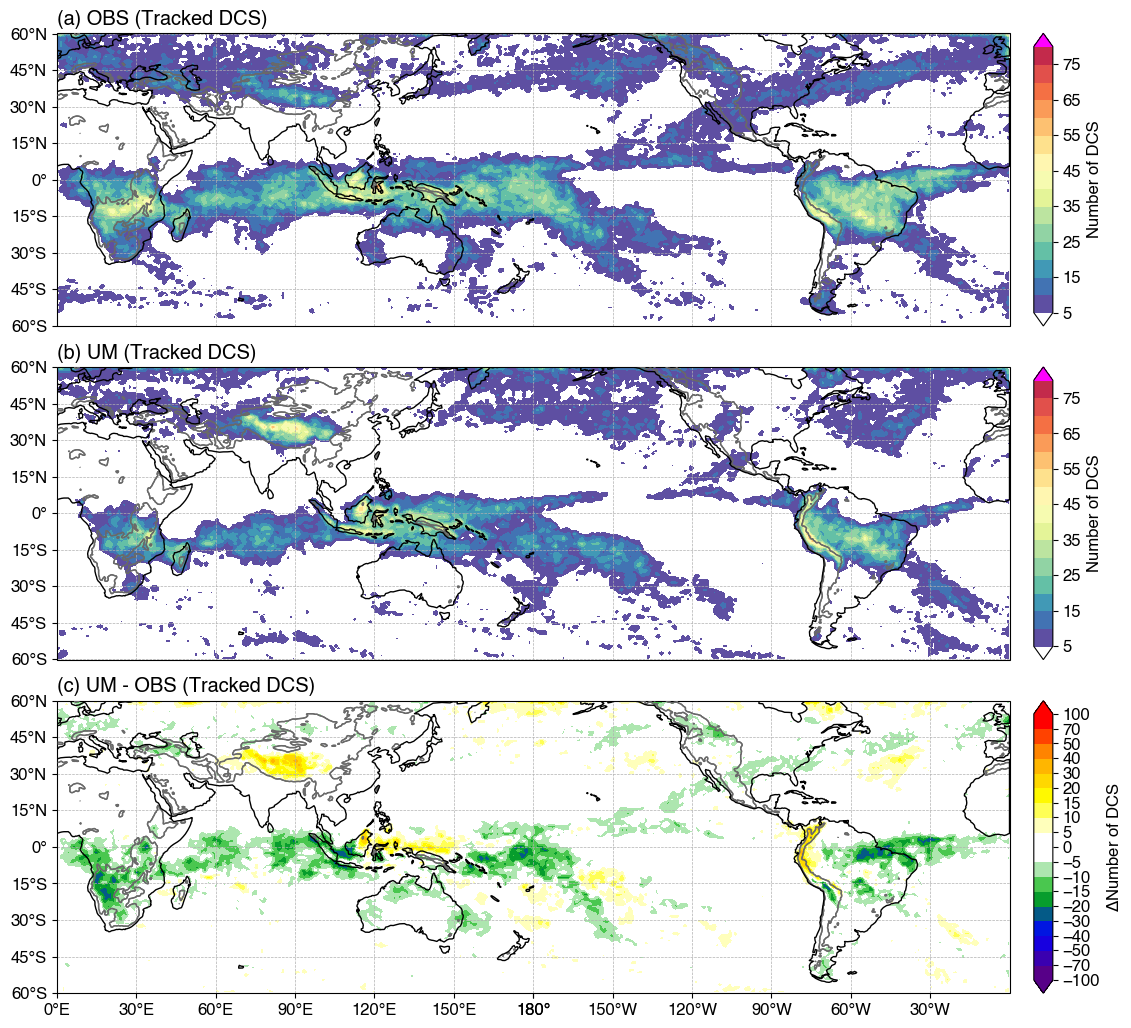

In [27]:
ccs_number_diff = ccs_number_mod - ccs_number_obs
# ccs_number_diff[np.abs(ccs_number_diff) < 1] = 0

titles = ['(a) OBS (Tracked DCS)', f'(b) {model_name[run_name]} (Tracked DCS)', f'(c) {model_name[run_name]} - OBS (Tracked DCS)']
dataarr = [ccs_number_obs, ccs_number_mod, ccs_number_diff]
min_nsample = 0
lev1 = np.arange(5,81,5)
# lev2 = [-60,-40,-30,-20,-10,0,10,20,30,40,60]
tick1 = np.arange(5,81,10)
# lev2 = np.arange(-100, 101, 10)
# tick2 = np.arange(-100, 101, 20)
lev2 = [-100,-70,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,70,100]
tick2 = lev2
levels = [lev1, lev1, lev2]
cbticks = [tick1, tick1, tick2]
cblabels = ['Number of DCS', 'Number of DCS', '$\Delta$Number of DCS']
cmap1 = copy.copy(mpl.cm.get_cmap("Spectral_r"))
cmap1 = truncate_colormap(cmap1, 0., 0.93)
cmap2 = generate_NCL_cmap('ViBlGrWhYeOrRe')
cmaps = [cmap1, cmap1, cmap2]
oob_colors = {'under':'white', 'over':'magenta'}
figname = f'{figdir}globalmap_obs_ccs_number_map_diff_{run_name}.png'
fig = plot_3maps(dataarr, lonbins, latbins, titles, levels, cmaps, cblabels, cbticks, figname, oob_colors=oob_colors, contourf=True)